<a href="https://colab.research.google.com/github/matthias-wright/flaxmodels/blob/main/flaxmodels/stylegan2/stylegan2_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pip
!pip install --upgrade jax jaxlib==0.1.66+cuda111 -f https://storage.googleapis.com/jax-releases/jax_releases.html
!pip install --upgrade git+https://github.com/matthias-wright/flaxmodels.git

Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
  Cloning https://github.com/matthias-wright/flaxmodels.git to /tmp/pip-req-build-7h3q5vj3
  Running command git clone -q https://github.com/matthias-wright/flaxmodels.git /tmp/pip-req-build-7h3q5vj3


# Generate images without truncation

In [ ]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import flaxmodels as fm

# Seed
key = jax.random.PRNGKey(1)

# Input noise
z = jax.random.normal(key, shape=(4, 512))

# Options for pretrained models:
# ['afhqcat', 'afhqdog', 'afhqwild', 'brecahad', 'car', 'cat', 'church', 'cifar10', 'ffhq', 'horse', 'metfaces']
generator = fm.stylegan2.Generator(pretrained='ffhq')
params = generator.init(key, z)
images = generator.apply(params, z, train=False)

# Normalize images to be in range [0, 1]
images = (images - jnp.min(images)) / (jnp.max(images) - jnp.min(images))

# Show images
fig, ax = plt.subplots(nrows=1, ncols=images.shape[0], figsize=(30, 5))
for i in range(images.shape[0]):
    ax[i].imshow(images[i])
    ax[i].axis('off')

# Generate images with truncation

Downloading: "https://www.dropbox.com/s/75klr5k6mgm7qdy/stylegan2_generator_metfaces.h5" to /tmp/flaxmodels/stylegan2_generator_metfaces.h5


100%|██████████| 133M/133M [00:04<00:00, 28.2MiB/s]


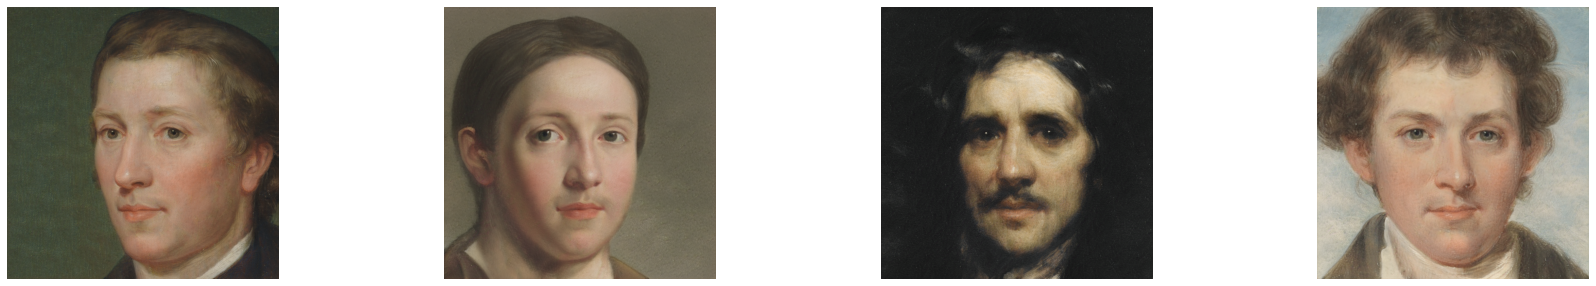

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import flaxmodels as fm

# Seed
key = jax.random.PRNGKey(0)

# Input noise
z = jax.random.normal(key, shape=(4, 512))

generator = fm.stylegan2.Generator(pretrained='metfaces')
params = generator.init(key, z, truncation_psi=0.5)
images = generator.apply(params, z, truncation_psi=0.5, train=False)

# Normalize images to be in range [0, 1]
images = (images - jnp.min(images)) / (jnp.max(images) - jnp.min(images))

# Show images
fig, ax = plt.subplots(nrows=1, ncols=images.shape[0], figsize=(30, 5))
for i in range(images.shape[0]):
    ax[i].imshow(images[i])
    ax[i].axis('off')

# Generate images with labels

Downloading: "https://www.dropbox.com/s/h1kmymjzfwwkftk/stylegan2_generator_cifar10.h5" to /tmp/flaxmodels/stylegan2_generator_cifar10.h5


100%|██████████| 80.9M/80.9M [00:01<00:00, 56.1MiB/s]


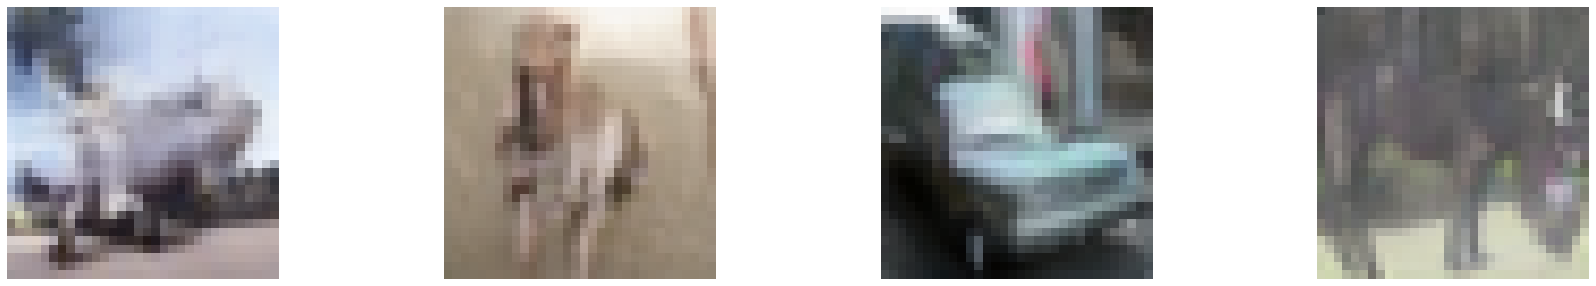

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import flaxmodels as fm

# Seed
key = jax.random.PRNGKey(0)

# Input noise
z = jax.random.normal(key, shape=(4, 512))

# Input labels
label = np.zeros((4, 10))
label[0, 0] = 1 # airplane
label[1, 5] = 1 # dog
label[2, 1] = 1 # car
label[3, 7] = 1 # horse
label = jnp.array(label)

# Options for pretrained models:
# ['afhqcat', 'afhqdog', 'afhqwild', 'brecahad', 'car', 'cat', 'church', 'cifar10', 'ffhq', 'horse', 'metfaces']
generator = fm.stylegan2.Generator(pretrained='cifar10')
params = generator.init(key, z, label)
images = generator.apply(params, z, label, train=False)

# Normalize images to be in range [0, 1]
images = (images - jnp.min(images)) / (jnp.max(images) - jnp.min(images))

# Show images
fig, ax = plt.subplots(nrows=1, ncols=images.shape[0], figsize=(30, 5))
for i in range(images.shape[0]):
    ax[i].imshow(images[i])
    ax[i].axis('off')

# Generate images with style mixing

(-0.5, 3091.5, 3091.5, -0.5)

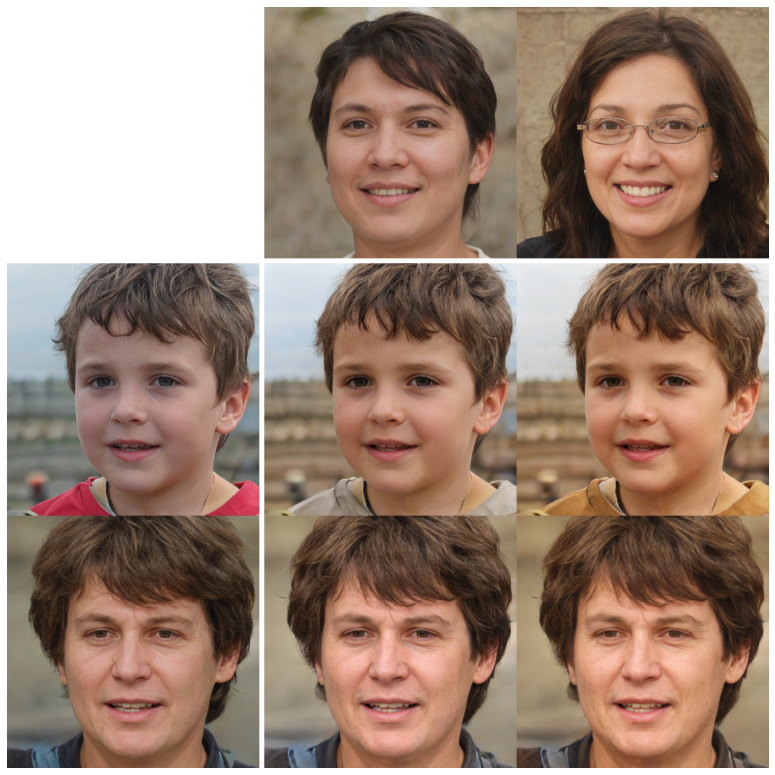

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import flaxmodels as fm

key = jax.random.PRNGKey(0)


# Initialize Mapping Network
mapping_net = fm.stylegan2.MappingNetwork(pretrained='ffhq')
mapping_params = mapping_net.init(key, jnp.zeros((1, 512)))

# Initialize Synthesis Network
synthesis_net = fm.stylegan2.SynthesisNetwork(pretrained='ffhq')
synthesis_params = synthesis_net.init(key, jnp.zeros((1, 18, 512)))

# Seeds
# If you have enough memory at your disposal, you can add more seeds to the rows/cols for more images
row_seeds = [21, 7]
col_seeds = [27, 42]
all_seeds = row_seeds + col_seeds

# Generate noise inputs, [minibatch, component]
all_z = jnp.concatenate([jax.random.normal(jax.random.PRNGKey(seed), shape=(1, 512)) for seed in all_seeds])

# Generate latent vectors, [minibatch, num_ws, component]
all_w = mapping_net.apply(mapping_params, all_z, truncation_psi=0.5, train=False)

# Generate images, [minibatch, H, W, 3]
all_images = synthesis_net.apply(synthesis_params, all_w)

# Normalize image to be in range [0, 1]
all_images = (all_images - jnp.min(all_images)) / (jnp.max(all_images) - jnp.min(all_images))

col_images = np.concatenate([all_images[i] for i in range(len(row_seeds))], axis=0)
row_images = np.concatenate([all_images[len(row_seeds) + i] for i in range(len(col_seeds))], axis=1)

images_grid = []

# Generate style mixing images
for row in range(len(row_seeds)):
    image_row = []
    for col in range(len(col_seeds)):
        # Combine first 9 dimensions from row seed latent w with last 9 dimensions from col seed latent w
        w = jnp.concatenate([all_w[row, :9], all_w[len(row_seeds) + col, 9:]], axis=0)
        # Add batch dimension
        w = jnp.expand_dims(w, axis=0)
        image = synthesis_net.apply(synthesis_params, w, train=False)
        # Remove batch dimension
        image = np.squeeze(image, axis=0)

        # Normalize image to be in range [0, 1]
        image = (image - jnp.min(image)) / (jnp.max(image) - jnp.min(image))
        image_row.append(image)
    image_row = np.concatenate(image_row, axis=1)
    images_grid.append(image_row)

images_grid = np.concatenate(images_grid, axis=0)

# Add row and column images to the grid
border = 20
grid = np.ones((row_images.shape[0] + images_grid.shape[0] + border, 
                col_images.shape[1] + images_grid.shape[1] + border,
                3))
grid[grid.shape[0] - images_grid.shape[0]:, grid.shape[1] - images_grid.shape[1]:] = images_grid
grid[:row_images.shape[0], grid.shape[1] - row_images.shape[1]:] = row_images
grid[grid.shape[0] - col_images.shape[0]:, :col_images.shape[1]] = col_images


plt.figure(figsize=(14, 14))
plt.imshow(np.clip(grid, 0, 1))
plt.axis('off')

# Get Discriminator outputs

In [6]:
import jax
import flaxmodels as fm

key = jax.random.PRNGKey(0)

img = jax.random.normal(key, shape=(1, 1024, 1024, 3))

discriminator = fm.stylegan2.Discriminator(pretrained='metfaces')
params = discriminator.init(key, img)
out = discriminator.apply(params, img)

Downloading: "https://www.dropbox.com/s/xnokaunql12glkd/stylegan2_discriminator_metfaces.h5" to /tmp/flaxmodels/stylegan2_discriminator_metfaces.h5


100%|██████████| 116M/116M [00:04<00:00, 26.0MiB/s]
